## **Introduction**

This notebook investigates **claim-level** veracity prediction on the **X-fact** dataset as part of a broader study on misinformation detection across multiple benchmarks. The goal is to evaluate how different modeling approaches capture the linguistic cues associated with factual correctness. The workflow includes dataset cleaning, majority-vote label consolidation, decontamination of train/validation/test splits, and systematic comparison of three baselines: TF–IDF + Complement Naive Bayes, FastText embeddings with a multilayer perceptron, and a fine-tuned XLM-RoBERTa classifier.


In [ ]:
!pip install -q datasets
!pip install -q transformers
!pip install -q gensim
!pip install -q evaluate

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset as HfDataset
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, average_precision_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import evaluate
import random
from pprint import pprint
import os
import nltk
import gensim.downloader as api

pd.set_option('future.no_silent_downcasting', True)

nltk.download("punkt")
nltk.download("punkt_tab")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/MyDrive/misinfo_project/x_fact_claim"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## **Dataset and Pre-processing**

The **X-Fact** subset of the ComplexDataLab Misinfo_Datasets is used, which contains multilingual fact-checking claims annotated as *false*, *true*, or *unknown*. Each example includes a claim text, 5 evidence, language, and multiple additional metadata fields.

The preprocessing pipeline consists of:
- Keeping only the `claim`, `veracity`, and `language` columns.
- Replacing literal `"na"` strings with missing values and dropping empty rows.
- Collapsing multiple annotations per claim using a majority vote (threshold 0.7).
- Removing any claims that appear across train/validation/test splits to avoid leakage.

After preprocessing, the final dataset contains **25,880** training examples, **3,682** validation examples, and **7,381** test examples, with no overlapping claims between splits.


In [ ]:
SUBSET_NAME = "x_fact"
TEXT_COL = "claim"
LABEL_COL = "veracity"
LANGUAGE_COL = "language"

In [ ]:
ds = load_dataset("ComplexDataLab/Misinfo_Datasets", SUBSET_NAME)
ds

In [ ]:
def hf_clean(ds_split, text_col=TEXT_COL, label_col=LABEL_COL, language_col=LANGUAGE_COL):
    df = ds_split.to_pandas()

    df = df.replace("na", np.nan)

    df = df[[text_col, label_col, language_col]].dropna()
    df[text_col]  = df[text_col].astype(str).str.strip()
    df[label_col] = df[label_col].astype(str).str.strip()
    df = df[(df[text_col] != "") & (df[label_col] != "")]

    return df

In [ ]:
def collapse_by_majority_label(df, text_col=TEXT_COL, label_col=LABEL_COL, language_col=LANGUAGE_COL, min_majority=0.7):
    # count labels per claim
    label_counts = (
        df.groupby([text_col, label_col])
          .size()
          .rename("count")
          .reset_index()
    )

    # for each claim, find majority label and its proportion
    total_per_claim = label_counts.groupby(text_col)["count"].transform("sum")
    label_counts["prop"] = label_counts["count"] / total_per_claim

    majority = (label_counts.sort_values("prop", ascending=False)
                           .drop_duplicates(subset=[text_col]))

    # keep only claims where majority label has enough support
    majority = majority[majority["prop"] >= min_majority]

    clean_df = majority[[text_col, label_col]].copy()
    languages = df[[text_col, language_col]].drop_duplicates(subset=[text_col])
    clean_df = clean_df.merge(languages, on=text_col, how="left")

    return clean_df

In [ ]:
clean_train_df = hf_clean(ds["train"])
clean_val_df = hf_clean(ds["validation"])
clean_test_df = hf_clean(ds["test"])

In [ ]:
train_df = collapse_by_majority_label(clean_train_df)
val_df = collapse_by_majority_label(clean_val_df)
test_df = collapse_by_majority_label(clean_test_df)

In [ ]:
print("Original train size:", len(clean_train_df))
print("After collapsing, train size:", len(train_df))
print("Original val size  :", len(clean_val_df))
print("After collapsing, val size  :", len(val_df))
print("Original test size :", len(clean_test_df))
print("After collapsing, test size :", len(test_df))

Original train size: 25923
After collapsing, train size: 25880
Original val size  : 3695
After collapsing, val size  : 3695
Original test size : 7413
After collapsing, test size : 7405


In [ ]:
train_claims = set(train_df[TEXT_COL])
val_claims   = set(val_df[TEXT_COL])
test_claims  = set(test_df[TEXT_COL])

# Pairwise overlaps
train_val_overlap  = train_claims & val_claims
train_test_overlap = train_claims & test_claims
val_test_overlap   = val_claims & test_claims

# Triple overlap (in all three splits)
all_three_overlap = train_claims & val_claims & test_claims

print("Unique claims per split:")
print(f"  Train: {len(train_claims)}")
print(f"  Val  : {len(val_claims)}")
print(f"  Test : {len(test_claims)}\n")

print("Overlapping claims:")
print(f"  Train ∩ Val      : {len(train_val_overlap)}")
print(f"  Train ∩ Test     : {len(train_test_overlap)}")
print(f"  Val ∩ Test       : {len(val_test_overlap)}")
print(f"  Train ∩ Val ∩ Test: {len(all_three_overlap)}")


Unique claims per split:
  Train: 25880
  Val  : 3695
  Test : 7405

Overlapping claims:
  Train ∩ Val      : 13
  Train ∩ Test     : 21
  Val ∩ Test       : 3
  Train ∩ Val ∩ Test: 0


In [ ]:
def remove_split_duplicates(train_df, val_df, test_df, text_col=TEXT_COL):
    """
    Remove examples from val and test sets that appear in train set
    """
    # Get unique claims from train set
    train_claims = set(train_df[text_col])

    # Remove duplicates from validation set
    val_df_clean = val_df[~val_df[text_col].isin(train_claims)].copy()

    # Remove duplicates from test set
    test_df_clean = test_df[~test_df[text_col].isin(train_claims)].copy()

    # Also remove any overlap between val and test
    val_claims_clean = set(val_df_clean[text_col])
    test_df_clean = test_df_clean[~test_df_clean[text_col].isin(val_claims_clean)]

    print(f"Removed {len(val_df) - len(val_df_clean)} duplicates from validation set")
    print(f"Removed {len(test_df) - len(test_df_clean)} duplicates from test set")
    print(f"Final sizes - Train: {len(train_df)}, Val: {len(val_df_clean)}, Test: {len(test_df_clean)}")

    return val_df_clean, test_df_clean

In [ ]:
val_df, test_df = remove_split_duplicates(train_df, val_df, test_df)

print("\nAfter deduplication:")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Removed 13 duplicates from validation set
Removed 24 duplicates from test set
Final sizes - Train: 25880, Val: 3682, Test: 7381

After deduplication:
Train: 25880, Val: 3682, Test: 7381


In [ ]:
# Verify no overlaps remain
train_claims_final = set(train_df[TEXT_COL])
val_claims_final = set(val_df[TEXT_COL])
test_claims_final = set(test_df[TEXT_COL])

print(f"Train ∩ Val: {len(train_claims_final & val_claims_final)}")
print(f"Train ∩ Test: {len(train_claims_final & test_claims_final)}")
print(f"Val ∩ Test: {len(val_claims_final & test_claims_final)}")

Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


In [ ]:
print("\nLabel values in train:")
print(train_df[LABEL_COL].value_counts())


Label values in train:
veracity
false      15690
true        8000
unknown     2190
Name: count, dtype: int64


In [ ]:
# unique labels from train
unique_labels = sorted(train_df[LABEL_COL].unique())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

print("Label mapping:")
print(label2id)

Label mapping:
{'false': 0, 'true': 1, 'unknown': 2}


In [ ]:
# Add numeric labels
train_df["labels"] = train_df[LABEL_COL].map(label2id)
val_df["labels"] = val_df[LABEL_COL].map(label2id)
test_df["labels"] = test_df[LABEL_COL].map(label2id)

In [ ]:
print(train_df.head())

                                               claim veracity language  labels
0  👆this little beautiful girl was seen in mangal...    false       ta       0
1  " 'denali' is the kenyan word for 'black power...    false       en       0
2  " 'scary' fact about our national debt. in 179...  unknown       en       2
3  " ... following world war ii war crime trials ...     true       en       1
4  " … if the agreement goes into effect, the mil...    false       en       0


## **Helpers for evalution**

## **Evaluation Utilities**


- **Confusion matrices** (raw counts + normalized):
  - Show which pairs of labels (`false`, `true`, `unknown`) are most frequently confused.
- **Macro-F1**:
  - Averages F1 across classes and is robust to class imbalance.
- **Macro and Micro AUPRC**:
  - Evaluate how well the model’s **probability scores** rank the true labels.
- **Expected Calibration Error (ECE)**:
  - Measures how well predicted probabilities reflect actual accuracy (e.g., “are 0.8-confidence predictions correct ~80% of the time?”).
- **Error tables**:
  - For each misclassified example, store:
    - the original text,
    - ground-truth label,
    - predicted label,
    - model confidence and per-class probabilities.

These utilities are shared by all models (Complement Naive Bayes, FastText+MLP, XLM-R) so their performance and typical errors can be directly compared.


In [ ]:
def plot_confusion(y_true, probs, id2label=id2label, normalize=False, title=None):
    """
    y_true: ground truth labels (numpy array)
    probs: predicted probabilities from model (numpy array)
    normalize: True → show percentages, False → raw counts
    """
    preds = probs.argmax(axis=1)

    cm = confusion_matrix(y_true, preds, normalize='true' if normalize else None)

    labels = [id2label[i] for i in sorted(id2label.keys())]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if title:
        plt.title(title)
    plt.show()

    return cm

In [ ]:
CLASS_IDS = sorted(id2label.keys())

def compute_auprc(probs, y_true, class_ids=CLASS_IDS):
    """
    probs: [N, num_classes]
    y_true: [N] (int labels)
    """
    y_bin = label_binarize(y_true, classes=class_ids)  # [N, C]
    auprc_macro = average_precision_score(y_bin, probs, average="macro")
    auprc_micro = average_precision_score(y_bin, probs, average="micro")
    return auprc_macro, auprc_micro


def compute_ece(probs, y_true, n_bins=15):
    """
    Simple Expected Calibration Error (ECE).
    probs: [N, num_classes]
    y_true: [N]
    """
    preds = probs.argmax(axis=1)
    confidences = probs.max(axis=1)
    correct = (preds == y_true).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i+1])
        if not np.any(mask):
            continue
        bin_conf = confidences[mask].mean()
        bin_acc  = correct[mask].mean()
        bin_frac = mask.mean()
        ece += bin_frac * abs(bin_conf - bin_acc)

    return float(ece)

In [ ]:
def evaluate_probs(probs, y_true, split_name, class_ids, id2label, n_bins=15):
    """
    probs: [N, num_classes]
    y_true: [N] int labels
    class_ids: list of class indices (e.g., CLASS_IDS = sorted(id2label.keys()))
    id2label: dict mapping id -> label string
    """
    preds = probs.argmax(axis=1)

    # Macro-F1
    macro_f1 = f1_score(y_true, preds, average="macro")

    # AUPRC
    auprc_macro, auprc_micro = compute_auprc(probs, y_true, class_ids=class_ids)

    # ECE
    ece = compute_ece(probs, y_true, n_bins=n_bins)

    print(f"\n=== {split_name} ===")
    print("Macro-F1     :", macro_f1)
    print("Macro AUPRC  :", auprc_macro)
    print("Micro AUPRC  :", auprc_micro)
    print("ECE          :", ece)
    print()
    print(
        classification_report(
            y_true,
            preds,
            target_names=[id2label[i] for i in class_ids],
            zero_division=0,
        )
    )

    metrics = {
        "macro_f1": macro_f1,
        "auprc_macro": auprc_macro,
        "auprc_micro": auprc_micro,
        "ece": ece,
    }

    return metrics, preds

In [ ]:
def evaluate_sklearn_clf(model, X, y, split_name,
                         class_ids=CLASS_IDS, id2label=id2label, n_bins=15):
    """
    Evaluate any sklearn classifier with predict_proba.
    Returns (metrics_dict, probs, preds).
    """
    probs = model.predict_proba(X)  # [N, C]
    metrics, preds = evaluate_probs(
        probs, y, split_name,
        class_ids=class_ids,
        id2label=id2label,
        n_bins=n_bins
    )
    return metrics, probs, preds

In [ ]:
def make_error_table(
    probs,
    y_true,
    texts,
    class_ids,
    id2label,
    languages,
    split_name,
    model_name,
):
    """
    Build a DataFrame of misclassified examples for X-Fact ONLY.

    probs: [N, C] numpy array of predicted probabilities
    y_true: [N] numpy array of int labels
    texts: list of raw texts (len N)
    languages: list of languages (len N)
    split_name: "train" / "val" / "test"
    model_name: "TFIDF+NB" / "FT+MLP" / "XLM-R"
    """
    preds = probs.argmax(axis=1)
    confs = probs.max(axis=1)

    rows = []
    for i, (p, gt, pred, conf, text, lang) in enumerate(
        zip(probs, y_true, preds, confs, texts, languages)
    ):
        if gt == pred:
            continue  # keep only misclassified examples

        row = {
            "idx": i,
            "text": text,
            "actual": id2label[int(gt)],
            "pred": id2label[int(pred)],
            "conf": float(conf),
            "language": lang,
            "split": split_name,
            "model": model_name,
        }

        # Per-class probabilities
        for c in class_ids:
            row[f"p_{id2label[c]}"] = float(p[c])

        rows.append(row)

    return pd.DataFrame(rows)


def show_errors(df, actual_label, pred_label, k=5, sort_by_conf=True):
    """
    Inspect misclassifications:
    actual_label, pred_label: strings like "false", "true", "unknown"
    """
    subset = df[(df["actual"] == actual_label) & (df["pred"] == pred_label)]

    if subset.empty:
        print(f"No examples for actual={actual_label}, pred={pred_label}")
        return

    if sort_by_conf:
        subset = subset.sort_values("conf", ascending=False)

    print(f"\n=== {len(subset)} examples where actual={actual_label}, pred={pred_label} ===\n")
    for _, row in subset.head(k).iterrows():
        print(f"[idx={row['idx']}] conf={row['conf']:.3f}")
        print("LANG:", row["language"])
        print("TEXT:", row["text"])
        print("ACTUAL:", row["actual"], "| PRED:", row["pred"])
        print("-" * 80)

## **TF-IDF + Complement Naive Bayes**

The first model is a **TF–IDF + Complement Naive Bayes** classifier:

- Claims are represented using **unigrams and bigrams** (`ngram_range=(1, 2)`).
- The vocabulary is capped at **100,000 features** and pruned with `min_df=2`.
- **ComplementNB** is well-suited for text classification with **imbalanced classes**.

In [ ]:
X_train = train_df[TEXT_COL].tolist()
y_train = train_df["labels"].to_numpy()

X_val   = val_df[TEXT_COL].tolist()
y_val   = val_df["labels"].to_numpy()

X_test  = test_df[TEXT_COL].tolist()
y_test  = test_df["labels"].to_numpy()

In [ ]:
print(X_train[0])
print(y_train[0])

👆this little beautiful girl was seen in mangalore with a group of tamil beggars.please forward until it reaches the right parent and she is identified. she knows her name & says she is sonal bipin patel.please post this photo on all your groups.the beggars say she was found in a train coming from mumbai.may be she can get her life back. 🙏
0


In [ ]:
tfidf_nb_clf = Pipeline(
    [
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=100_000,
            min_df=2
        )),
        ("cnb", ComplementNB())
    ]
)

In [ ]:
tfidf_nb_clf.fit(X_train, y_train)

In [ ]:
metrics_train_nb, train_probs_nb, train_preds_nb = evaluate_sklearn_clf(
    tfidf_nb_clf, X_train, y_train, "Train (TFIDF+NB) on X-fact(claim)"
)
metrics_val_nb,   val_probs_nb,   val_preds_nb   = evaluate_sklearn_clf(
    tfidf_nb_clf, X_val,   y_val,   "Validation (TFIDF+NB) on X-fact(claim)"
)
metrics_test_nb,  test_probs_nb,  test_preds_nb  = evaluate_sklearn_clf(
    tfidf_nb_clf, X_test,  y_test,  "Test (TFIDF+NB) on X-fact(claim)"
)


=== Train (TFIDF+NB) on X-fact(claim) ===
Macro-F1     : 0.7173770888605565
Macro AUPRC  : 0.8475089599354447
Micro AUPRC  : 0.8502927065612376
ECE          : 0.17914571001090313

              precision    recall  f1-score   support

       false       0.90      0.73      0.81     15690
        true       0.70      0.81      0.75      8000
     unknown       0.47      0.81      0.59      2190

    accuracy                           0.76     25880
   macro avg       0.69      0.78      0.72     25880
weighted avg       0.80      0.76      0.77     25880


=== Validation (TFIDF+NB) on X-fact(claim) ===
Macro-F1     : 0.5047581581018122
Macro AUPRC  : 0.5270464788485593
Micro AUPRC  : 0.6981091585022308
ECE          : 0.04534285869021853

              precision    recall  f1-score   support

       false       0.80      0.65      0.72      2256
        true       0.49      0.57      0.53      1140
     unknown       0.20      0.37      0.26       286

    accuracy                      

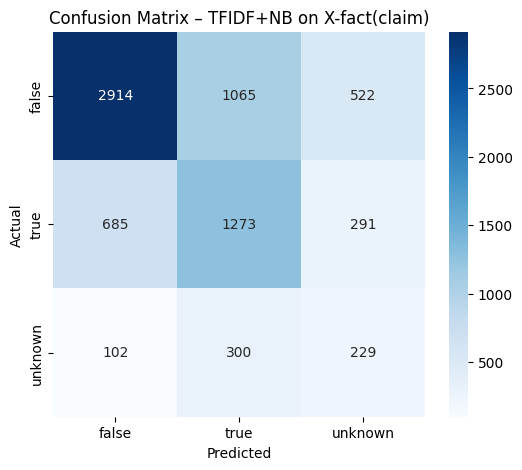

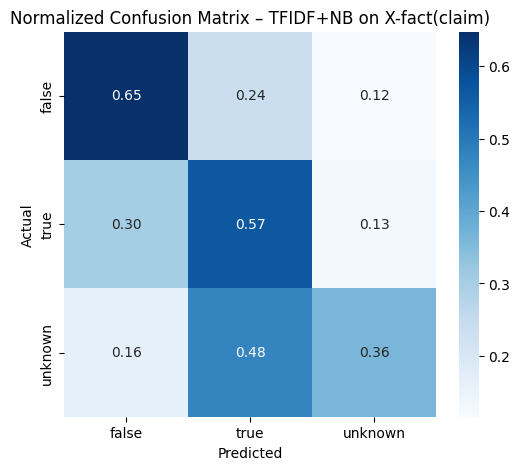

In [ ]:
cm_nb = plot_confusion(
    y_true=y_test,
    probs=test_probs_nb,
    title="Confusion Matrix – TFIDF+NB on X-fact(claim)"
)

cm_nb_norm = plot_confusion(
    y_true=y_test,
    probs=test_probs_nb,
    normalize=True,
    title="Normalized Confusion Matrix – TFIDF+NB on X-fact(claim)"
)

In [ ]:
errors_nb_test = make_error_table(
    probs=test_probs_nb,
    y_true=y_test,
    texts=X_test,
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_df[LANGUAGE_COL].tolist(),
    split_name="test",
    model_name="TFIDF+NB"
)

In [ ]:
print("Total misclassified examples:", len(errors_nb_test))

Total misclassified examples: 2965


In [ ]:
errors_nb_test.head()

,idx,text,actual,pred,conf,language,split,model,p_false,p_true,p_unknown
0,0,😱😱aconteceu na malásia ontem!!😱😱 [[**compartil...,false,true,0.397576,pt,test,TFIDF+NB,0.383977,0.397576,0.218447
1,1,""" ‘obamacare’ puts the federal government betw...",false,unknown,0.391607,en,test,TFIDF+NB,0.329889,0.278504,0.391607
2,6,"""(birmingham, ala.) is the cradle of the civil...",false,true,0.405652,en,test,TFIDF+NB,0.275439,0.405652,0.318910
3,7,"""(deborah) ross defends those who want to burn...",true,false,0.349195,en,test,TFIDF+NB,0.349195,0.302437,0.348368
4,8,"""(hillary clinton's state department) actually...",true,unknown,0.364103,en,test,TFIDF+NB,0.286215,0.349683,0.364103


In [ ]:
nb_errors_path = os.path.join(output_dir, "x_fact_nb_test_errors.csv")
errors_nb_test.to_csv(nb_errors_path, index=False)

print("Saved NB test errors to:", nb_errors_path)

Saved NB test errors to: /content/drive/MyDrive/misinfo_project/x_fact_claim/x_fact_nb_test_errors.csv


## **FastText Embeddings + MLP**

The second model is a **shallow neural model** that uses pre-trained **FastText** word embeddings combined with a small MLP:

1. **Tokenization & Embeddings**
   - Each claim is tokenized with `nltk.word_tokenize`.
   - **Only alphabetic** tokens are retained, and a **300-dimensional** FastText vector is obtained for each token.
   - Token vectors are **averaged** to produce a single sentence embedding per claim, followed by **L2-normalization**.

2. **MLP Architecture**
   - Input: 300-dim sentence vector.
   - Two hidden layers of size 256 and 128 with **ReLU** activations.
   - **Dropout (0.3)** after each hidden layer to reduce overfitting.
   - Output: 3-way softmax for `false`, `true`, `unknown`.

3. **Training Details**
   - Loss: Cross-entropy with **class weights** derived from the training label distribution to counter imbalance.
   - Optimizer: Adam with learning rate `1e-3`.
   - Strategy: up to **100 epochs** with **early stopping** based on validation macro-F1.

After training, the model is evaluated with the same metrics (Macro-F1, AUPRC, ECE, confusion matrices, error tables) to see how much a shallow neural approach improves over the lexical baseline.


In [ ]:
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def tokenize(text):
    tokens = nltk.word_tokenize(text.lower())
    return [token for token in tokens if token.isalpha()]

In [ ]:
def sent_to_vec(tokens, model, dim):
    vecs = [model[w] for w in tokens if w in model]
    if not vecs:
        return np.zeros(dim, dtype=np.float32)
    v = np.mean(vecs, axis=0)

    norm = np.linalg.norm(v)
    if norm > 0:
        v = v / norm

    return v.astype(np.float32)

def build_features(df, text_col, model, dim):
    X = np.vstack([
        sent_to_vec(tokenize(t), model, dim)
        for t in df[text_col].tolist()
    ])
    y = df["labels"].to_numpy()
    return X, y

In [ ]:
X_train_ft, y_train_ft = build_features(train_df, TEXT_COL, fasttext_model, 300)
X_val_ft, y_val_ft = build_features(val_df, TEXT_COL, fasttext_model, 300)
X_test_ft, y_test_ft = build_features(test_df, TEXT_COL, fasttext_model, 300)

In [ ]:
X_train_ft.shape

(25880, 300)

In [ ]:
class FT_Dataset(TorchDataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __getitems__(self, indices):
        return [self.__getitem__(i) for i in indices]

train_ds = FT_Dataset(X_train_ft, y_train_ft)
val_ds = FT_Dataset(X_val_ft, y_val_ft)
test_ds = FT_Dataset(X_test_ft, y_test_ft)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

In [ ]:
class FastTextMLP(nn.Module):
    def __init__(self, input_dim=300, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [ ]:
num_classes = len(CLASS_IDS)

class_counts = np.bincount(y_train, minlength=num_classes).astype(np.float32)
print("Counts:", class_counts)

# inverse-frequency style weights
class_weights = class_counts.sum() / (num_classes * class_counts)
print("Weights:", class_weights)

class_weights_t = torch.tensor(class_weights, dtype=torch.float32).to(device)

Counts: [15690.  8000.  2190.]
Weights: [0.5498194 1.0783334 3.9391172]


In [ ]:
model = FastTextMLP().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(y.cpu().numpy())
            total_loss += loss.item()
    return (total_loss / len(loader),
            np.vstack(all_probs),
            np.concatenate(all_labels))


In [ ]:
best_f1 = 0.0
best_val_loss = float("inf")
patience = 10
wait = 0
EPOCHS = 100
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader)
    val_loss, val_probs, val_labels = eval_epoch(model, val_loader)
    val_preds = val_probs.argmax(axis=1)
    val_macro_f1 = f1_score(val_labels, val_preds, average="macro")

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Macro F1: {val_macro_f1:.4f}")

    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        wait = 0
        best_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)

Epoch 01 | Train Loss: 0.9851 | Val Loss: 0.9059 | Val Macro F1: 0.4273
Epoch 02 | Train Loss: 0.9308 | Val Loss: 0.8809 | Val Macro F1: 0.4584
Epoch 03 | Train Loss: 0.9206 | Val Loss: 0.8753 | Val Macro F1: 0.4494
Epoch 04 | Train Loss: 0.9115 | Val Loss: 0.8772 | Val Macro F1: 0.4727
Epoch 05 | Train Loss: 0.9082 | Val Loss: 0.8705 | Val Macro F1: 0.4564
Epoch 06 | Train Loss: 0.9052 | Val Loss: 0.8695 | Val Macro F1: 0.4624
Epoch 07 | Train Loss: 0.9019 | Val Loss: 0.8747 | Val Macro F1: 0.4544
Epoch 08 | Train Loss: 0.8955 | Val Loss: 0.8721 | Val Macro F1: 0.4506
Epoch 09 | Train Loss: 0.8918 | Val Loss: 0.8750 | Val Macro F1: 0.4454
Epoch 10 | Train Loss: 0.8916 | Val Loss: 0.8661 | Val Macro F1: 0.4696
Epoch 11 | Train Loss: 0.8868 | Val Loss: 0.8748 | Val Macro F1: 0.4603
Epoch 12 | Train Loss: 0.8849 | Val Loss: 0.8655 | Val Macro F1: 0.4730
Epoch 13 | Train Loss: 0.8815 | Val Loss: 0.8715 | Val Macro F1: 0.4639
Epoch 14 | Train Loss: 0.8795 | Val Loss: 0.8683 | Val Macro F1:

<All keys matched successfully>

In [ ]:
train_loss, train_probs, train_labels = eval_epoch(model, train_loader)
val_loss, val_probs,   val_labels   = eval_epoch(model, val_loader)
test_loss,  test_probs,  test_labels  = eval_epoch(model, test_loader)

print(f"\nTrain loss: {train_loss:.4f}")
metrics_train_mlp = evaluate_probs(train_probs, train_labels, "Train (FT+MLP)  on X-fact", CLASS_IDS, id2label, n_bins=15)

print(f"\nValidation loss: {val_loss:.4f}")
metrics_val_mlp   = evaluate_probs(val_probs,   val_labels,   "Validation (FT+MLP)  on X-fact", CLASS_IDS, id2label, n_bins=15)

print(f"\nTest loss: {test_loss:.4f}")
metrics_test_mlp  = evaluate_probs(test_probs,  test_labels,  "Test (FT+MLP) on X-fact", CLASS_IDS, id2label, n_bins=15)


Train loss: 0.8337

=== Train (FT+MLP)  on X-fact ===
Macro-F1     : 0.5085957574884615
Macro AUPRC  : 0.5491071814909283
Micro AUPRC  : 0.6429364247435161
ECE          : 0.06230495195185198

              precision    recall  f1-score   support

       false       0.85      0.52      0.65     15690
        true       0.51      0.55      0.53      8000
     unknown       0.23      0.78      0.35      2190

    accuracy                           0.55     25880
   macro avg       0.53      0.62      0.51     25880
weighted avg       0.69      0.55      0.58     25880


Validation loss: 0.8880

=== Validation (FT+MLP)  on X-fact ===
Macro-F1     : 0.4588146557335892
Macro AUPRC  : 0.4920147498120477
Micro AUPRC  : 0.6084860226732636
ECE          : 0.09797056091343302

              precision    recall  f1-score   support

       false       0.83      0.50      0.63      2256
        true       0.45      0.49      0.47      1140
     unknown       0.17      0.66      0.28       286

    a

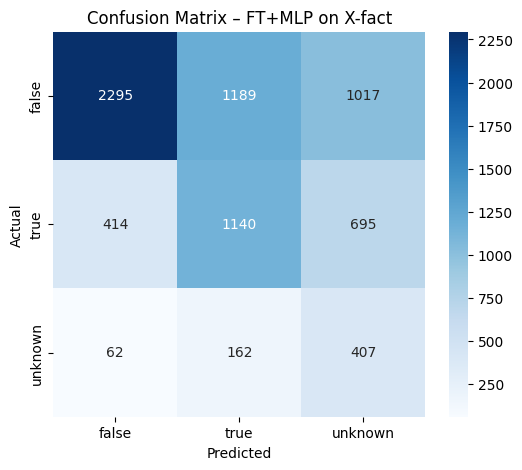

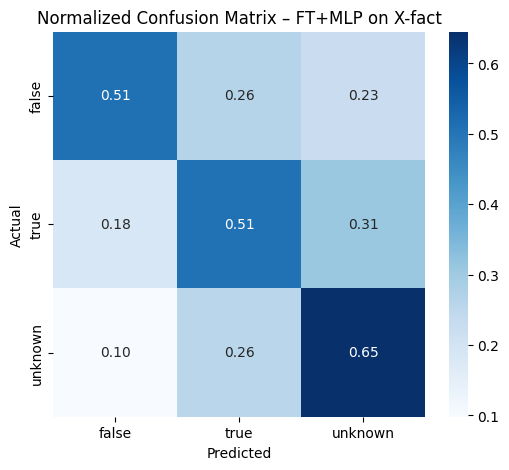

In [ ]:
cm_ft = plot_confusion(
    y_true=test_labels,
    probs=test_probs,
    title="Confusion Matrix – FT+MLP on X-fact"
)

cm_ft_norm = plot_confusion(
    y_true=test_labels,
    probs=test_probs,
    normalize=True,
    title="Normalized Confusion Matrix – FT+MLP on X-fact"
)

In [ ]:
errors_FT_MLP_test = make_error_table(
    probs=test_probs,
    y_true=test_labels,
    texts=test_df[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_df[LANGUAGE_COL].tolist(),
    split_name="test",
    model_name="FastText+MLP"
)

In [ ]:
FT_MLP_errors_path = os.path.join(output_dir, "x_fact_FT_MLP_test_errors.csv")
errors_FT_MLP_test.to_csv(FT_MLP_errors_path, index=False)

print("Saved FT+MLP test errors to:", FT_MLP_errors_path)

Saved FT+MLP test errors to: /content/drive/MyDrive/misinfo_project/x_fact_claim/x_fact_FT_MLP_test_errors.csv


In [ ]:
print("Total misclassified examples:", len(errors_FT_MLP_test))

Total misclassified examples: 3539


## **Fine-Tuning XLM-RoBERTa**

The final baseline uses a **transformer-based model**, `xlm-roberta-base`, fine-tuned on the FEVER dataset.

1. **HuggingFace Dataset Conversion**

   * The cleaned pandas DataFrames are converted into HuggingFace `Dataset` objects with the following fields:

     * `text` – the claim,
     * `labels` – the encoded veracity label.

2. **Tokenization**

   * The XLM-R tokenizer is applied with:

     * `max_length = 128`,
     * `padding = "max_length"`,
     * `truncation = True`.
   * Each instance is transformed into `(input_ids, attention_mask, labels)` in PyTorch format.

3. **Model and Training Setup**

   * The base architecture is `xlm-roberta-base`, loaded through `AutoModelForSequenceClassification` with a classification head for 3 labels.
   * A custom `WeightedTrainer` is used, which:

     * applies **class weights** within the cross-entropy loss,
     * computes evaluation metrics such as accuracy, macro-F1, macro/micro AUPRC, and ECE during training.
   * Training arguments include:

     * `learning_rate = 2e-5`,
     * `batch_size = 16`,
     * `num_train_epochs = 5`,
     * `warmup_ratio = 0.1`,
     * `weight_decay = 0.01`,
     * evaluation performed at the end of each epoch.

4. **Evaluation**

   - After fine-tuning, the model is evaluated on the train, validation, and test splits using the shared evaluation utilities.
   - Confusion matrices and detailed error tables are generated for the misclassified test examples.

This setup enables direct comparison between **lexical**, **shallow neural**, and **transformer-based** approaches under a unified evaluation framework.


**Build HuggingFace Dataset objects from the cleaned dataframes**

In [ ]:
train_hf = HfDataset.from_pandas(train_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
val_hf = HfDataset.from_pandas(val_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
test_hf = HfDataset.from_pandas(test_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))

In [ ]:
print(train_hf[0])

{'text': '👆this little beautiful girl was seen in mangalore with a group of tamil beggars.please forward until it reaches the right parent and she is identified. she knows her name & says she is sonal bipin patel.please post this photo on all your groups.the beggars say she was found in a train coming from mumbai.may be she can get her life back. 🙏', 'labels': 0}


**Tokenizer and encodings**

In [ ]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
  return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


train_encodings = train_hf.map(tokenize, batched=True)
val_encodings = val_hf.map(tokenize, batched=True)
test_encodings = test_hf.map(tokenize, batched=True)


train_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
print(train_encodings[0])

{'labels': tensor(0), 'input_ids': tensor([     0,      6, 245109, 100231,  10176,  34923,  23040,    509,  51592,
            23,  46337,   1484,     13,    678,     10,  21115,    111,  54470,
         32834,   1970,      7,      5,   8705,   6991,  40225,  24189,    442,
         58359,     90,     70,   7108,  49129,    136,   2412,     83, 207487,
             5,   2412,  93002,    604,   9351,    619,  17378,   2412,     83,
           775,    289,    333,   5128,    249,   1708,      5,   8705,   6991,
          1305,    903,  16186,     98,    756,    935,  94407,      5,   2347,
         32834,   1970,      7,   5154,   2412,    509,  14037,     23,     10,
         25550,  38162,   1295,  42555,  28449,      5,  11354,    186,   2412,
           831,   2046,    604,   6897,   4420,      5,      6, 113612,      2,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
     

**Define model**

In [ ]:
num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

In [ ]:
metric_acc = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    macro_f1 = f1_score(labels, preds, average="macro")

    probs = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()

    auprc_macro, auprc_micro = compute_auprc(probs, labels, class_ids=CLASS_IDS)
    ece = compute_ece(probs, labels, n_bins=15)

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_auprc": auprc_macro,
        "micro_auprc": auprc_micro,
        "ece": ece,
    }

In [ ]:
def trainer_eval_with_report(trainer, dataset, split_name):
    out = trainer.predict(dataset)
    logits = out.predictions
    y_true = out.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()
    metrics, preds = evaluate_probs(
        probs, y_true,
        split_name,
        class_ids=CLASS_IDS,
        id2label=id2label,
        n_bins=15
    )
    return metrics, probs, y_true

In [ ]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss = F.cross_entropy(
            logits, labels,
            weight=self.class_weights.to(logits.device) if self.class_weights is not None else None
        )

        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/misinfo_project/bert_models/x-fact_xlmr",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=False,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=200,
    report_to="none",
    save_total_limit=1
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=val_encodings,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_t
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Auprc,Micro Auprc,Ece
1,0.944600,0.829907,0.541825,0.482034,0.523408,0.697995,0.076318
2,0.903700,0.817501,0.517382,0.471032,0.518942,0.648949,0.139541
3,0.867600,0.827805,0.518197,0.475700,0.523437,0.626136,0.178258
4,0.765700,0.896308,0.531776,0.481607,0.527445,0.587807,0.178429
5,0.710600,0.988957,0.574416,0.501186,0.525194,0.655070,0.174387


TrainOutput(global_step=8090, training_loss=0.8491954591277209, metrics={'train_runtime': 1580.8358, 'train_samples_per_second': 81.855, 'train_steps_per_second': 5.118, 'total_flos': 8511719063500800.0, 'train_loss': 0.8491954591277209, 'epoch': 5.0})

In [ ]:
metrics_train_xlmr = trainer_eval_with_report(trainer, train_encodings, "Train (XLM-R) on X-fact")
metrics_val_xlmr = trainer_eval_with_report(trainer, val_encodings,  "Validation (XLM-R) on X-fact")
metrics_test_xlmr = trainer_eval_with_report(trainer, test_encodings, "Test (XLM-R) on X-fact")


=== Train (XLM-R) on X-fact ===
Macro-F1     : 0.6533059143059362
Macro AUPRC  : 0.742931260497727
Micro AUPRC  : 0.7799900083371523
ECE          : 0.07258016931863251

              precision    recall  f1-score   support

       false       0.93      0.60      0.73     15690
        true       0.57      0.80      0.67      8000
     unknown       0.42      0.85      0.56      2190

    accuracy                           0.68     25880
   macro avg       0.64      0.75      0.65     25880
weighted avg       0.77      0.68      0.70     25880




=== Validation (XLM-R) on X-fact ===
Macro-F1     : 0.5011857310313288
Macro AUPRC  : 0.5251937748455412
Micro AUPRC  : 0.6550698455386063
ECE          : 0.17438665302728323

              precision    recall  f1-score   support

       false       0.87      0.54      0.67      2256
        true       0.47      0.67      0.55      1140
     unknown       0.21      0.47      0.29       286

    accuracy                           0.57      3682
   macro avg       0.51      0.56      0.50      3682
weighted avg       0.69      0.57      0.60      3682




=== Test (XLM-R) on X-fact ===
Macro-F1     : 0.5073020820206757
Macro AUPRC  : 0.5279297557694589
Micro AUPRC  : 0.6640443546430956
ECE          : 0.16909194008765577

              precision    recall  f1-score   support

       false       0.85      0.55      0.67      4501
        true       0.47      0.67      0.55      2249
     unknown       0.23      0.45      0.30       631

    accuracy                           0.58      7381
   macro avg       0.52      0.56      0.51      7381
weighted avg       0.68      0.58      0.60      7381



In [ ]:
test_output = trainer.predict(test_encodings)

logits_xlmr = test_output.predictions
test_labels_xlmr = test_output.label_ids
test_probs_xlmr = torch.softmax(torch.tensor(logits_xlmr), dim=-1).cpu().numpy()

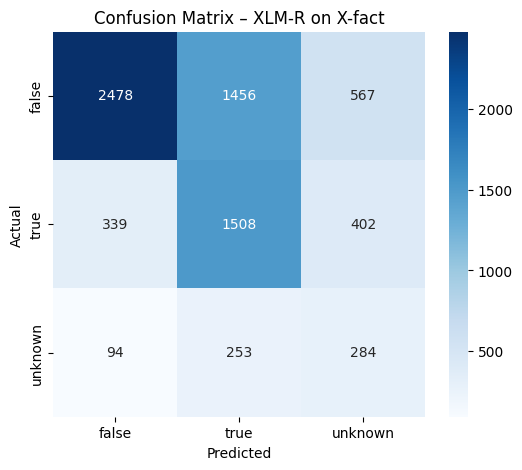

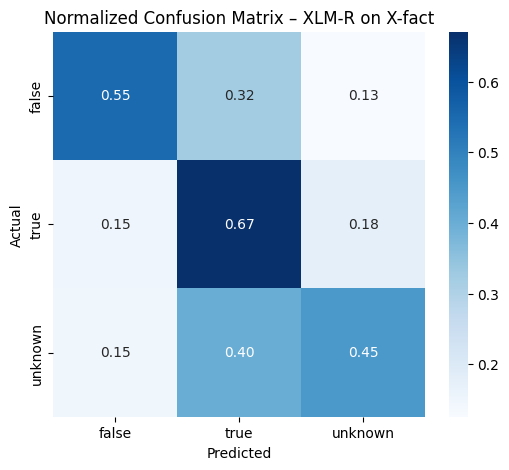

In [ ]:
cm_xlmr = plot_confusion(
    y_true=test_labels_xlmr,
    probs=test_probs_xlmr,
    title="Confusion Matrix – XLM-R on X-fact"
)

cm_xlmr_norm = plot_confusion(
    y_true=test_labels_xlmr,
    probs=test_probs_xlmr,
    normalize=True,
    title="Normalized Confusion Matrix – XLM-R on X-fact"
)

In [ ]:
errors_xlmr_test = make_error_table(
    probs=test_probs_xlmr,
    y_true=test_labels_xlmr,
    texts=test_df[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_df[LANGUAGE_COL].tolist(),
    split_name="test",
    model_name="XLM-R",
)

In [ ]:
errors_xlmr_test.head()

,idx,text,actual,pred,conf,language,split,model,p_false,p_true,p_unknown
0,3,"""$120,000 will be spent by taxpayers on charli...",true,false,0.714409,en,test,XLM-R,0.714409,0.256359,0.029231
1,4,"""$360 million of our tax dollars went straight...",true,unknown,0.566386,en,test,XLM-R,0.365805,0.067809,0.566386
2,7,"""(deborah) ross defends those who want to burn...",true,unknown,0.437782,en,test,XLM-R,0.352000,0.210218,0.437782
3,8,"""(hillary clinton's state department) actually...",true,false,0.409351,en,test,XLM-R,0.409351,0.255077,0.335572
4,10,"""(john) kasich was the architect who balanced ...",unknown,false,0.494438,en,test,XLM-R,0.494438,0.328135,0.177427


In [ ]:
XLMR_errors_path = os.path.join(output_dir, "x_fact_XLMR_test_errors.csv")
errors_xlmr_test.to_csv(XLMR_errors_path, index=False)

print("Saved XLMR test errors to:", XLMR_errors_path)

Saved XLMR test errors to: /content/drive/MyDrive/misinfo_project/x_fact_claim/x_fact_XLMR_test_errors.csv


## **Error Analysis Across Models**

To complement aggregate metrics, qualitative error analysis is conducted for all models.

* For each model (TF–IDF+NB, FastText+MLP, and XLM-R), the saved **test-set error tables** are loaded.
* The frequency of each misclassification pair `(actual_label → predicted_label)` is summarized.
* High-confidence errors—cases where the predicted probability is high but the prediction is incorrect—are inspected.
* Representative examples are examined for the most common confusion patterns (e.g., `unknown → true`, `true → false`).

This analysis helps identify:

* whether certain labels are systematically confused,
* whether high-confidence mistakes involve patterns such as **negation**, **subtle phrasing**, or **world-knowledge requirements**,
* and whether XLM-R reduces specific error types relative to the lexical or shallow neural baselines.




In [ ]:
def summarize_errors(df):
    print("\n=== Error Counts by (actual → pred) ===")
    print(df.groupby(["actual", "pred"]).size())

    if "language" in df.columns:
        print("\n=== Errors by language (counts) ===")
        lang_counts = df["language"].value_counts()
        print(lang_counts)

        print("\n=== Errors by language (percentage) ===")
        print((lang_counts / len(df) * 100).round(2).astype(str) + "%")

    print("\n=== Top 10 high-confidence wrong predictions ===")
    print(
        df.sort_values("conf", ascending=False)
          .head(10)[["idx", "text", "actual", "pred", "conf", "language"]]
    )

In [ ]:
def inspect_top_error_pairs(df, top_n=3, k=5):
    pair_counts = (
        df.groupby(["actual", "pred"]).size()
          .sort_values(ascending=False)
          .head(top_n)
    )

    print("\nTop error pairs:")
    print(pair_counts)

    for (actual, pred), _ in pair_counts.items():
        show_errors(df, actual_label=actual, pred_label=pred, k=k)


In [ ]:
errors_nb_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_claim/x_fact_nb_test_errors.csv")
errors_FT_MLP_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_claim/x_fact_FT_MLP_test_errors.csv")
errors_xlmr_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_claim/x_fact_XLMR_test_errors.csv")

In [ ]:
print("Total misclassified examples for NB:", len(errors_nb_test))
print("Total misclassified examples for FT+MLP:", len(errors_FT_MLP_test))
print("Total misclassified examples for XLM-R:", len(errors_xlmr_test))

Total misclassified examples for NB: 2965
Total misclassified examples for FT+MLP: 3539
Total misclassified examples for XLM-R: 3111


In [ ]:
summarize_errors(errors_nb_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       1065
         unknown     522
true     false       685
         unknown     291
unknown  false       102
         true        300
dtype: int64

=== Errors by language (counts) ===
language
en    1484
pt     544
ka     202
pl     145
es     144
it     116
tr     105
ro      68
ta      67
id      36
sr      25
ar      16
de      13
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en    50.05%
pt    18.35%
ka     6.81%
pl     4.89%
es     4.86%
it     3.91%
tr     3.54%
ro     2.29%
ta     2.26%
id     1.21%
sr     0.84%
ar     0.54%
de     0.44%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text   actual   pred  \
2486  5483  الرئيس التركي، رجب طيب أردوغان، يعلن نجاح بلاد...     true  false   
2487  5504  امرأة مسنة يمنية ماتت دون أن يسأل عنها أحد، وم...  unknown  false   
2134  4566  schwangere wi

In [ ]:
inspect_top_error_pairs(errors_nb_test, top_n=3, k=5)


Top error pairs:
actual  pred   
false   true       1065
true    false       685
false   unknown     522
dtype: int64

=== 1065 examples where actual=false, pred=true ===

[idx=3742] conf=0.823
LANG: pl
TEXT: polska nie jest zjednoczonym królestwem wielkiej brytanii i irlandii północnej, gdzie są wręcz formalnoprawne wymogi i nakazy, żeby poseł, który występuje z partii, złożył mandat. mniej więcej rok temu członek izby gmin, parlamentarzysta partii konserwatywnej, odszedł do ukip i wówczas odbyły się natychmiast wybory w jego okręgu, które zresztą wygrał.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=2735] conf=0.820
LANG: pl
TEXT: głosowaliśmy wszyscy przeciwko trzem rezolucjom, ale niestety większość, w przypadku jednej z rezolucji nieduża, bo tylko 15 głosów, opowiedziała się za tą wizją większej konsolidacji wewnątrz unii europejskiej, więcej metody wspólnotowej, powstanie eurostrefy, budżetu eurostrefy, ba, nawet

In [ ]:
summarize_errors(errors_FT_MLP_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       1189
         unknown    1017
true     false       414
         unknown     695
unknown  false        62
         true        162
dtype: int64

=== Errors by language (counts) ===
language
en    1635
pt     845
ka     228
es     172
pl     149
it     119
tr     109
ro      91
ta      84
id      44
sr      25
de      20
ar      17
hi       1
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en     46.2%
pt    23.88%
ka     6.44%
es     4.86%
pl     4.21%
it     3.36%
tr     3.08%
ro     2.57%
ta     2.37%
id     1.24%
sr     0.71%
de     0.57%
ar     0.48%
hi     0.03%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text actual   pred  \
1982  3663  perhutani mengklarifikasi penemuan lahan pembi...   true  false   
174    272  "foto wanita iran yang menonton piala dunia ta...   true  false   
1126  1

In [ ]:
inspect_top_error_pairs(errors_FT_MLP_test, top_n=3, k=5)


Top error pairs:
actual  pred   
false   true       1189
        unknown    1017
true    unknown     695
dtype: int64

=== 1189 examples where actual=false, pred=true ===

[idx=2715] conf=0.861
LANG: tr
TEXT: genişbant abone sayısı 38 milyona ulaştı
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=4955] conf=0.848
LANG: tr
TEXT: tüketici kredisi, banka kredi kartı borç batağıdır. borç batağındaki vatandaş sayımız 5 milyon
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=3198] conf=0.841
LANG: tr
TEXT: mevcut iktidarın desteklediği kadın politikaları ile hayatı evle sınırlı kadın sayısı 4 milyonu aştı.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=4614] conf=0.834
LANG: it
TEXT: spesa per armi: fratoianni dà numeri imprecisi
ACTUAL: false | PRED: true
-------------------------------------------

In [ ]:
summarize_errors(errors_xlmr_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       1456
         unknown     567
true     false       339
         unknown     402
unknown  false        94
         true        253
dtype: int64

=== Errors by language (counts) ===
language
en    1424
pt     653
ka     232
pl     150
es     147
tr     113
it     113
ro      94
ta      78
id      41
sr      30
ar      19
de      17
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en    45.77%
pt    20.99%
ka     7.46%
pl     4.82%
es     4.73%
tr     3.63%
it     3.63%
ro     3.02%
ta     2.51%
id     1.32%
sr     0.96%
ar     0.61%
de     0.55%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text actual     pred  \
2442  5086          video viral polisi menendang muka ibu-ibu   true    false   
1097  2236  dinkes aceh membantah atas isu pelajar lumpuh ...   true    false   
2886  6793  “indochina” d

In [ ]:
inspect_top_error_pairs(errors_xlmr_test, top_n=3, k=5)


Top error pairs:
actual  pred   
false   true       1456
        unknown     567
true    unknown     402
dtype: int64

=== 1456 examples where actual=false, pred=true ===

[idx=6175] conf=0.944
LANG: ta
TEXT: தமிழகத்தில் அரசு சார்பில் அளிக்கப்பட்ட நீட் பயிற்சி மையத்தில் பயின்ற 19 ஆயிரம் மாணவர்களில் ஒருவருக்கு கூட அரசு மருத்துவக் கல்லூரிகளில் இடம் கிடைக்கவில்லை.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=6154] conf=0.933
LANG: ta
TEXT: கர்நாடகாவில் 20 வருடங்களுக்கு முன்பு 90,000 ஏக்கராக இருந்த விவசாய இடங்கள் இப்போது 26,50,000 ஏக்கராக உயர்ந்துள்ளது.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=2876] conf=0.929
LANG: en
TEXT: in oregon, 12,808 people were arrested for marijuana-related crimes in 2012.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=6076] conf=0.924
LANG: ta
TEXT: இந்தியாவ